# LOS Tabular

## Setup

In [3]:
# First install package from terminal:
!pip install -U pip
!pip install -U setuptools wheel
!pip install autogluon  # autogluon==0.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 29.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.9 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.3
    Uninstalling wheel-0.38.3:
      Successfully uninstalled wheel-0.38.3
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires je

In [1]:
# import all required modules
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

pd.set_option('display.max_rows', None)  ###
pd.set_option('display.max_columns', None)  ###
pd.set_option('display.width', None)  ###
pd.set_option('display.max_colwidth', None)  ###

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import cohen_kappa_score
from sklearn.inspection import permutation_importance

In [2]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:  
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)
  # connect your colab with the drive
  drive.mount(mount)

 # Switch to the directory on the Google Drive that you want to use
  import os
  path_to_repo = mount + "/MyDrive/MIMIC-III Text Mining/LOS_FINAL/"

else:
   path_to_repo = os.path.dirname(os.getcwd())

  
print(path_to_repo)

path_to_data = f"{path_to_repo}data/"
path_to_raw = f"{path_to_data}raw/"
path_to_processed = f"{path_to_data}processed/"
path_to_icd = f"{path_to_data}icd_codes/"
path_to_models = f"{path_to_repo}models/"
path_to_results = f"{path_to_repo}results/"

We're running Colab
Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive
/content/gdrive/MyDrive/MIMIC-III Text Mining/LOS_FINAL/


## Import and clean the dataset

In [4]:
# import dataset
file = f'{path_to_processed}df_mixed_discharge.csv.gzip'
raw_df = pd.read_csv(file, compression = 'gzip', low_memory=False)

In [5]:
# examine the variables (names)
raw_df.columns

Index(['hadm_id', 'subject_id', 'ethnicity', 'admission_type',
       'admission_location', 'insurance', 'religion', 'marital_status',
       'icu_los', 'gender', 'age', 'urea_n_min', 'urea_n_max', 'urea_n_mean',
       'platelets_min', 'platelets_max', 'platelets_mean', 'magnesium_max',
       'albumin_min', 'calcium_min', 'resprate_min', 'resprate_max',
       'resprate_mean', 'glucose_min', 'glucose_max', 'glucose_mean', 'hr_min',
       'hr_max', 'hr_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean',
       'diasbp_min', 'diasbp_max', 'diasbp_mean', 'temp_min', 'temp_max',
       'temp_mean', 'sapsii', 'sofa', 'urine_min', 'urine_mean', 'urine_max',
       'patientweight', 'age_cat', 'type_stay', 'prev_adm', 'dest_discharge',
       'emergency_dpt', 'icd_chapter', 'origin_patient', 'los', 'text'],
      dtype='object')

In [38]:
# drop the variables to be exempted from the analysis and rename new dataset
df = raw_df.drop(columns = ['hadm_id', 'subject_id','icu_los'])

In [39]:
# Transform the LOS timedelta to days (as decimal values to increase precision)
df['los'] = pd.to_timedelta(df.los)
df['los'] = df.los/pd.to_timedelta(1, unit='D')

In [40]:
# selection criterion : only patients 18 and older and with a length of stay or 1 day or greater
df = df.loc[(df['age']>=18) & (df['los']>=1),:]
# compare size of dataframe before and after selection
len(raw_df), len(df)

(30985, 30764)

In [41]:
# check proportion of missing values
missing = pd.DataFrame(df.isna().mean(), columns = ['proportions'])
missing.sort_values('proportions',ascending = False)

,proportions
patientweight,0.482610
albumin_min,0.341406
calcium_min,0.026622
glucose_mean,0.002080
glucose_max,0.002080
glucose_min,0.002080
magnesium_max,0.002080
temp_mean,0.001463
temp_max,0.001463
temp_min,0.001463


In [42]:
# drop variables having more than 20 % missing values
print(f"Variables with more than 20% Missing Values: {list(missing.loc[missing.proportions >= 0.2].index)}")
df = df.drop(columns=missing.loc[missing.proportions >= 0.2].index)

Variables with more than 20% Missing Values: ['albumin_min', 'patientweight']


In [43]:
# impute missing values
df = df.interpolate()
df.isna().mean()

ethnicity             0.0
admission_type        0.0
admission_location    0.0
insurance             0.0
religion              0.0
marital_status        0.0
gender                0.0
age                   0.0
urea_n_min            0.0
urea_n_max            0.0
urea_n_mean           0.0
platelets_min         0.0
platelets_max         0.0
platelets_mean        0.0
magnesium_max         0.0
calcium_min           0.0
resprate_min          0.0
resprate_max          0.0
resprate_mean         0.0
glucose_min           0.0
glucose_max           0.0
glucose_mean          0.0
hr_min                0.0
hr_max                0.0
hr_mean               0.0
sysbp_min             0.0
sysbp_max             0.0
sysbp_mean            0.0
diasbp_min            0.0
diasbp_max            0.0
diasbp_mean           0.0
temp_min              0.0
temp_max              0.0
temp_mean             0.0
sapsii                0.0
sofa                  0.0
urine_min             0.0
urine_mean            0.0
urine_max   

## Binarize LOS

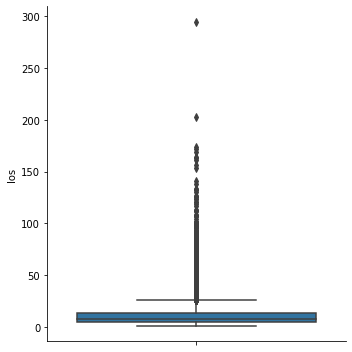

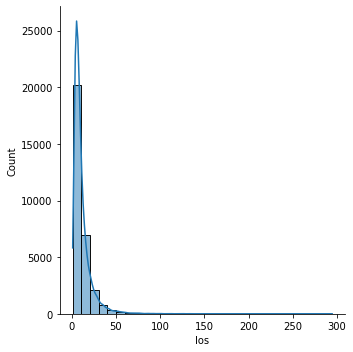

In [44]:
# check distribution of outcome
sns.catplot(kind='box', data=df, y='los');
sns.displot(data=df, x="los", bins=30, kde=True) ;

In [45]:
# compute Lower and Upper Fence according to Tukey's criteria
y = df['los']
Q1 = np.percentile(y, 25)
Q3 = np.percentile(y, 75)
IQR = Q3-Q1
LF = Q1 - 1.5*IQR
UF = Q3 + 1.5*IQR
print(f'First quartile = {Q1:.3f}, Third Quartile = {Q3:.3f}, Interquartile Interval = {IQR:.3f}')
print(f'Lower Fence = {LF:.3f}, Upper Fence = {UF:.3f}')

First quartile = 5.051, Third Quartile = 13.388, Interquartile Interval = 8.338
Lower Fence = -7.456, Upper Fence = 25.895


In [46]:
# create categorical LOS variable where prolonged LOS is any value greater than Upper Fence
df['los_cat'] = df['los']> UF
df = df.drop(columns=['los', 'text'])

In [47]:
# split the data into training and test
df_train, df_test = train_test_split(df, train_size=0.80, stratify = df['los_cat'], random_state=42)

## Train the Tabular Model (Structured DataSet)

In [49]:
# paramètres du modèle
save_path = f'{path_to_models}tabular'
label = 'los_cat'
metric = 'roc_auc'

In [50]:
# run the tabular predictor ensemble of models
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label=label, eval_metric=metric,path=save_path)
predictor.fit(df_train)

INFO:autogluon.tabular.learner.default_learner:Beginning AutoGluon training ...
INFO:autogluon.tabular.learner.default_learner:AutoGluon will save models to "/content/gdrive/MyDrive/MIMIC-III Text Mining/LOS_FINAL/models/tabular/"
INFO:autogluon.tabular.learner.default_learner:AutoGluon Version:  0.5.2
INFO:autogluon.tabular.learner.default_learner:Python Version:     3.7.15
INFO:autogluon.tabular.learner.default_learner:Operating System:   Linux
INFO:autogluon.tabular.learner.default_learner:Train Data Rows:    24611
INFO:autogluon.tabular.learner.default_learner:Train Data Columns: 46
INFO:autogluon.tabular.learner.default_learner:Label Column: los_cat
INFO:autogluon.tabular.learner.default_learner:Preprocessing data ...
Level 25:autogluon.core.utils.utils:AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
INFO:autogluon.core.utils.utils:	2 unique label values:  [False, True]
Level 25:autogluon.core.utils.utils:	If 'binary' is not t

In [51]:
# evaluate performance on the test set
per_tab = predictor.evaluate(df_test)
per_tab

INFO:autogluon.tabular.learner.abstract_learner:Evaluation: roc_auc on test data: 0.9441635626643294
INFO:autogluon.tabular.learner.abstract_learner:Evaluations on test data:
INFO:autogluon.tabular.learner.abstract_learner:{
    "roc_auc": 0.9441635626643294,
    "accuracy": 0.9471802372826263,
    "balanced_accuracy": 0.7051531003505697,
    "mcc": 0.5348751697099995,
    "f1": 0.5376955903271693,
    "precision": 0.7411764705882353,
    "recall": 0.421875
}


{'roc_auc': 0.9441635626643294,
 'accuracy': 0.9471802372826263,
 'balanced_accuracy': 0.7051531003505697,
 'mcc': 0.5348751697099995,
 'f1': 0.5376955903271693,
 'precision': 0.7411764705882353,
 'recall': 0.421875}

In [52]:
# save the class and probability predictions
y_pred = predictor.predict(df_test)
y_pred_proba = predictor.predict_proba(df_test).iloc[:,1]

In [53]:
# compute other metrics
def perf(y_test, y_pred, y_pred_proba):
  kappa = cohen_kappa_score(y_test, y_pred)
  precision, recall, prc_th = precision_recall_curve(y_test, y_pred_proba)
  prc_auc = auc(recall, precision)
  return kappa, prc_auc

perf = perf(df_test['los_cat'], y_pred, y_pred_proba)
perf_dict = {"Cohen's Kappa": perf[0], "PRC AUC": perf[1]}
perf_dict

{"Cohen's Kappa": 0.5119144639388208, 'PRC AUC': 0.6552421524932525}

In [54]:
# compare the different models
leaderboard = predictor.leaderboard(df_test)
leaderboard

                  model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2    0.944164   0.947699        0.991313       0.611941  77.569073                 0.007473                0.001650           2.109876            2       True         14
1            LightGBMXT    0.942363   0.941051        0.034004       0.017004   2.565246                 0.034004                0.017004           2.565246            1       True          3
2              CatBoost    0.942151   0.942311        0.021171       0.019160  10.475738                 0.021171                0.019160          10.475738            1       True          7
3              LightGBM    0.939862   0.943836        0.053804       0.015399   0.994170                 0.053804                0.015399           0.994170            1       True          4
4         LightGBMLarge    0.939767   0.

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.944164,0.947699,0.991313,0.611941,77.569073,0.007473,0.001650,2.109876,2,True,14
1,LightGBMXT,0.942363,0.941051,0.034004,0.017004,2.565246,0.034004,0.017004,2.565246,1,True,3
2,CatBoost,0.942151,0.942311,0.021171,0.019160,10.475738,0.021171,0.019160,10.475738,1,True,7
3,LightGBM,0.939862,0.943836,0.053804,0.015399,0.994170,0.053804,0.015399,0.994170,1,True,4
4,LightGBMLarge,0.939767,0.940326,0.033478,0.014446,1.982131,0.033478,0.014446,1.982131,1,True,13
5,XGBoost,0.939601,0.942521,0.059786,0.019948,1.384621,0.059786,0.019948,1.384621,1,True,11
6,NeuralNetTorch,0.938218,0.941053,0.142741,0.071025,31.319077,0.142741,0.071025,31.319077,1,True,12
7,RandomForestEntr,0.935201,0.929563,0.261513,0.210181,3.555715,0.261513,0.210181,3.555715,1,True,6
8,NeuralNetFastAI,0.932655,0.939189,0.124151,0.063857,26.482290,0.124151,0.063857,26.482290,1,True,10
9,RandomForestGini,0.927101,0.926989,0.272703,0.210461,3.242278,0.272703,0.210461,3.242278,1,True,5


In [55]:
# compute feature importance
importance = predictor.feature_importance(df_test)
importance

INFO:autogluon.core.utils.utils:Computing feature importance via permutation shuffling for 46 features using 5000 rows with 5 shuffle sets...
INFO:autogluon.core.utils.utils:	227.34s	= Expected runtime (45.47s per shuffle set)
INFO:autogluon.core.utils.utils:	84.23s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
urea_n_max,0.040859,0.005030,0.000027,5,0.051215,0.030503
platelets_min,0.037140,0.004077,0.000017,5,0.045534,0.028746
platelets_max,0.025476,0.003742,0.000054,5,0.033180,0.017772
urea_n_min,0.015645,0.001430,0.000008,5,0.018590,0.012700
platelets_mean,0.008963,0.001691,0.000145,5,0.012446,0.005481
temp_max,0.003965,0.001156,0.000776,5,0.006344,0.001586
dest_discharge,0.003747,0.001076,0.000734,5,0.005962,0.001531
calcium_min,0.003073,0.000855,0.000651,5,0.004834,0.001312
icd_chapter,0.002958,0.001045,0.001592,5,0.005109,0.000807
type_stay,0.002354,0.000970,0.002797,5,0.004351,0.000357


In [56]:
# feature importance in percentage
importance['percent'] = 100*importance['importance']/importance['importance'].max()
importance

,importance,stddev,p_value,n,p99_high,p99_low,percent
urea_n_max,0.040859,0.005030,0.000027,5,0.051215,0.030503,100.000000
platelets_min,0.037140,0.004077,0.000017,5,0.045534,0.028746,90.898162
platelets_max,0.025476,0.003742,0.000054,5,0.033180,0.017772,62.350431
urea_n_min,0.015645,0.001430,0.000008,5,0.018590,0.012700,38.290474
platelets_mean,0.008963,0.001691,0.000145,5,0.012446,0.005481,21.937421
temp_max,0.003965,0.001156,0.000776,5,0.006344,0.001586,9.703999
dest_discharge,0.003747,0.001076,0.000734,5,0.005962,0.001531,9.170172
calcium_min,0.003073,0.000855,0.000651,5,0.004834,0.001312,7.521710
icd_chapter,0.002958,0.001045,0.001592,5,0.005109,0.000807,7.239703
type_stay,0.002354,0.000970,0.002797,5,0.004351,0.000357,5.760560


In [58]:
perf_dict.update(per_tab)

In [59]:
# save performances
df_perf = pd.DataFrame.from_dict(perf_dict, orient='index', columns=['performances'])
df_perf.to_excel(path_to_results+'tabular/df_perf.xlsx')

In [60]:
# save leaderboard
leaderboard.to_excel(path_to_results+'tabular/leaderboard.xlsx')

In [61]:
# save importance
importance.to_excel(path_to_results+'tabular/importance.xlsx')